# 03 — Modeling & Evaluation

This notebook trains multiple classification models on the preprocessed dataset.
The goals are:

- Build baseline classifiers
- Evaluate accuracy, recall, precision, F1-score and ROC AUC
- Compare model performance
- Identify strong and weak predictors
- Produce a ranked comparison table

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np

from src.config import RANDOM_STATE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Dummy Model
from sklearn.dummy import DummyClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)

# Cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Processed Data

In [3]:
X_train = pd.read_csv("../data/processed/X_train_preprocessed.csv")
X_test  = pd.read_csv("../data/processed/X_test_preprocessed.csv")

y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test  = pd.read_csv("../data/processed/y_test.csv").values.ravel()

## 1.1 Dataset Overview (Sanity Check)

Before modeling, we verify the integrity of the preprocessed dataset.


In [4]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Target distribution (train):")
print(pd.Series(y_train).value_counts(normalize=True))

Train shape: (455, 36)
Test shape: (114, 36)
Target distribution (train):
0    0.626374
1    0.373626
Name: proportion, dtype: float64


## 2. Baseline Performance

Before testing real models, it's important to measure the performance of a 
baseline classifier. This helps evaluate whether more complex models are 
actually learning meaningful patterns.

In [5]:
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
baseline_pred = baseline.predict(X_test)

baseline_acc = accuracy_score(y_test, baseline_pred)
print(f"Baseline accuracy: {baseline_acc:.3f}")

Baseline accuracy: 0.632


## 3. Models to Train

- Logistic Regression
- Random Forest
- SVM (Linear Kernel)
- KNN
- Gradient Boosting

In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

## 4. Model Training & Initial Evaluation

Each model is trained using the preprocessed data.

Metrics: accuracy, precision, recall, F1-score and ROC AUC.

In [7]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1-score": f1_score(y_test, pred),
        "ROC AUC": roc_auc_score(y_test, prob) if prob is not None else None
    })

## 5. Performance Comparison Table

In [8]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1-score,ROC AUC
0,Logistic Regression,0.982456,1.000000,0.952381,0.975610,1.000000
1,Random Forest,0.938596,0.926829,0.904762,0.915663,0.992063
2,SVM (Linear Kernel),0.973684,1.000000,0.928571,0.962963,0.994709
3,KNN,0.991228,1.000000,0.976190,0.987952,0.999669
4,Gradient Boosting,0.938596,0.926829,0.904762,0.915663,0.991733


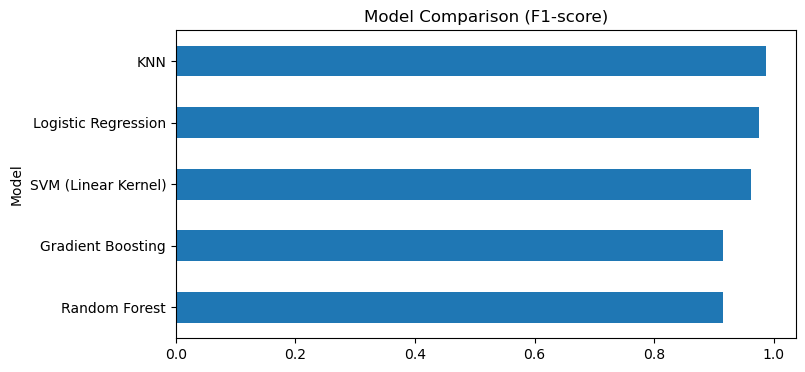

In [9]:
results_df.set_index("Model")["F1-score"].sort_values().plot(
    kind="barh", figsize=(8,4), title="Model Comparison (F1-score)"
)
plt.show()

## 6. Confusion Matrix

We visualize the confusion matrix for the best-performing model based on F1-score.

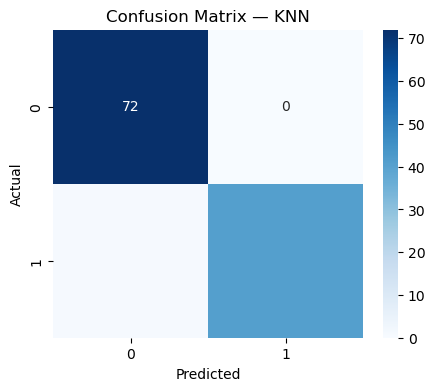

In [10]:
best_model_name = results_df.sort_values("F1-score", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

best_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 7. ROC Curve

ROC curves show how well the model separates the two classes.

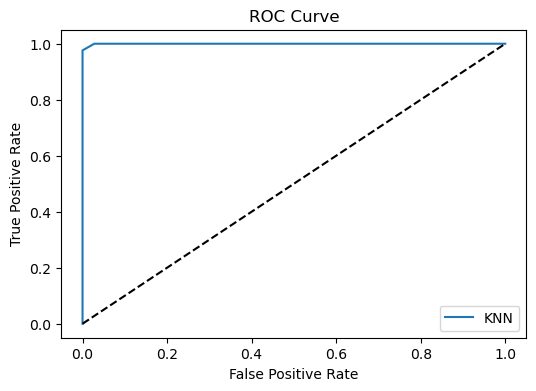

In [11]:
best_prob = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, best_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"{best_model_name}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 8. Cross-Validation

We use stratified K-fold cross-validation to evaluate model stability.


In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    print(f"{name}: mean F1 = {scores.mean():.4f} (+/- {scores.std():.4f})")


Logistic Regression: mean F1 = 0.9730 (+/- 0.0113)
Random Forest: mean F1 = 0.9166 (+/- 0.0322)
SVM (Linear Kernel): mean F1 = 0.9579 (+/- 0.0239)
KNN: mean F1 = 0.9451 (+/- 0.0160)
Gradient Boosting: mean F1 = 0.9321 (+/- 0.0283)


## 9. Feature Importance

Tree-based models allow inspection of feature importance.

In [13]:
rf = models["Random Forest"]
importances = pd.Series(rf.feature_importances_, index=X_train.columns)

importances.sort_values(ascending=False).head(15)

perimeter_worst         0.179613
radius_worst            0.121323
area_worst              0.111785
concave_points_worst    0.080024
concave_points_mean     0.078969
perimeter_avg           0.059810
area_avg                0.046449
perimeter_mean          0.037070
concavity_mean          0.036361
radius_avg              0.034091
area_mean               0.021230
radius_mean             0.018689
concavity_worst         0.014372
area_se                 0.013252
smoothness_worst        0.013058
dtype: float64

## 10. Final Summary

- A baseline classifier was evaluated for comparison.
- Multiple models were trained using consistent preprocessing.
- Performance was measured with accuracy, precision, recall, F1-score and ROC AUC.
- Confusion matrices and ROC curves were generated for the best model.
- Cross-validation confirmed robustness.
- Feature importance revealed the strongest predictors.
- Best model: **KNN**

The KNN model performed best, likely because the dataset was standardized 
and contains strong local patterns in feature space, which benefits 
distance-based algorithms.

Note: Since this is a medical dataset and false negatives are critical, 
F1-score and Recall were prioritized over Accuracy.

## Exporting best model

In [14]:
import joblib

joblib.dump(best_model, "../src/models/best_model.pkl")

['../src/models/best_model.pkl']